In [1]:
import re
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing  # to L2-normalize the existing vectors
from beautifultable import BeautifulTable
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Create pandas dataframe 'rat_df' from 'BX-Book-Ratings.csv' file
# Delete all the rows from dataframe which have rating = 0
rat_df = pd.read_csv("BX-Book-Ratings.csv")
rat_df = rat_df.where(rat_df['rating'] != 0).dropna()

# Create pandas dataframe 'book_df' from 'BX-Books.csv' file
book_df = pd.read_csv("BX-Books.csv")

## Preprocessing data 

In [3]:
# Text-cleaning function
def clean_and_reform_data(text):
    delete_items = ["&#39;", "&quot;"]
    for item in delete_items:
        text = text.replace(item, ' ')
    # remove punctuation marks
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    # make lowercase
    text = text.lower()
    return text

In [4]:
book_df['Clean'] = book_df['summary'].apply(clean_and_reform_data)

# Remove stopwords
stop_words = set(stopwords.words('english'))
book_df['WithoutStop'] = book_df['Clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [5]:
# Splitting each summary into a list of words
summaries_splitted = []
for summary in book_df['WithoutStop']:
    temp = summary.split()
    summaries_splitted.append(temp)

In [6]:
# Creating the Word2Vec model
word2vec_model = Word2Vec(sentences = summaries_splitted, vector_size = 150, workers = 6) # take the summaries_splitted

In [7]:
# Create the word-summary vectors
def create_doc_vectors(data_tokens, word2vec_model):
    features = []
    for tokens in data_tokens:
        zero_vector = np.zeros(word2vec_model.vector_size)
        vectors = []
        for token in tokens:
            if token in word2vec_model.wv:
                vectors.append(word2vec_model.wv[token])
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis = 0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features

vectorized_doc = create_doc_vectors(summaries_splitted, word2vec_model) # vectorized summaries

In [8]:
# Perform L2-normalization of the summary vectors
normalized_doc = preprocessing.normalize(vectorized_doc)

In [9]:
# Linear dimensionality reduction to 2D using SVD of the data to project it to a lower dimensional space
reduced_features = PCA(n_components = 2).fit_transform(normalized_doc)

## Perform Elbow Method for determining the optimal k 

In [10]:
wcss = []
K = range(1,10)
for k in K:
    kmeans = KMeans(n_clusters = k, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    y_data = kmeans.fit_predict(reduced_features)
    wcss.append(kmeans.inertia_)

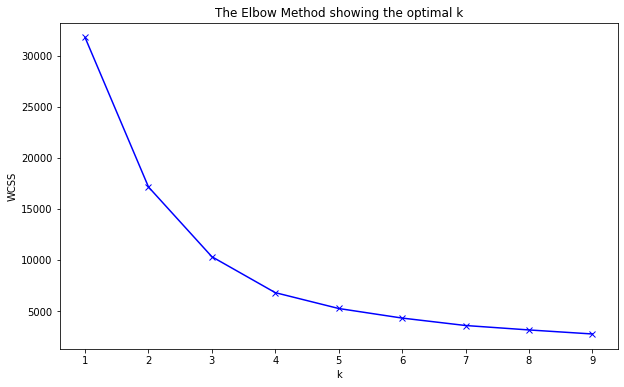

In [11]:
plt.figure(figsize=(10,6))
plt.plot(K, wcss, 'bx-')
plt.xlabel('k')
plt.ylabel('WCSS')
plt.title('The Elbow Method showing the optimal k')
plt.show()

## Perform k-means clustering 

In [12]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)  
y_data = kmeans.fit_predict(reduced_features)

In [13]:
def clusters_plotting(features, y_pred, model, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(features[y_pred == 0, 0],
                features[y_pred == 0, 1], marker = "x", c = 'red', s = 100, label = ['c1'])
    plt.scatter(features[y_pred == 1, 0],
                features[y_pred == 1, 1], marker = "x", c = 'blue', s = 100, label = ['c2'])
    plt.scatter(features[y_pred == 2, 0],
                features[y_pred == 2, 1], marker = "x", c = 'orange', s = 100, label = ['c3'])
    plt.scatter(model.cluster_centers_[:,0],
                model.cluster_centers_[:,1], marker = "o", c = 'black', label = 'centroids')
    plt.legend()
    plt.title(title)

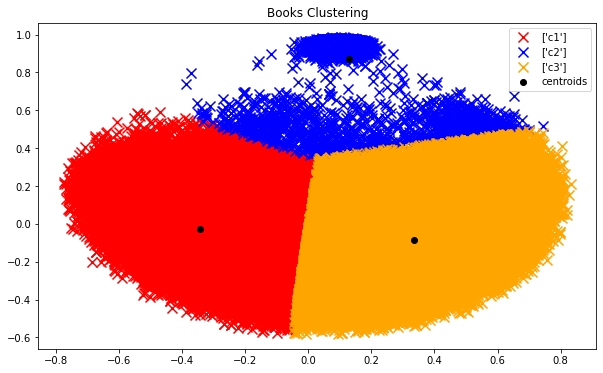

In [14]:
clusters_plotting(reduced_features, y_data, kmeans, 'Books Clustering')

In [15]:
# Store the cluster labels of each summary in 'book_df'
book_df['cluster'] = kmeans.labels_

In [16]:
# Perform inner join between 'rat_df' and 'book_df' dataframes
merged = pd.merge(rat_df, book_df, on='isbn')

## Load the users' demographics 

In [17]:
# Create pandas dataframe 'usr_df' from 'BX-Users.csv' file
usr_df = pd.read_csv("BX-Users.csv")

In [18]:
# Turn each value of the 'location' column into a list
usr_df['location'] = usr_df['location'].str.split(', ').tolist() # use comma as a separator for split

In [19]:
# Perform inner join between 'usr_df' and 'merged' dataframes
merged2 = pd.merge(usr_df, merged, on='uid')

In [20]:
# Extract the countries from each 'location' list
for idx, row in merged2.iterrows():
    if len(merged2.loc[idx,'location']) == 3:
        if merged2.loc[idx,'location'][2] == ',':
            merged2.loc[idx,'location'] = 'unknown'
        else:
            merged2.loc[idx,'location'] = merged2.loc[idx,'location'][2]
    
    elif len(merged2.loc[idx,'location']) == 4:
        if merged2.loc[idx,'location'][3] == ',':
            merged2.loc[idx,'location'] = 'unknown'
        else:
            merged2.loc[idx,'location'] = merged2.loc[idx,'location'][3]
    
    elif len(merged2.loc[idx,'location']) == 5:
        merged2.loc[idx,'location'] = merged2.loc[idx,'location'][4]
    
    elif len(merged2.loc[idx,'location']) == 2:
        if merged2.loc[idx,'location'][1] == ',':
            merged2.loc[idx,'location'] = 'unknown'
        else:
            merged2.loc[idx,'location'] = merged2.loc[idx,'location'][1]

In [21]:
# Remove punctuation marks from the values of 'location' column
merged2['location'] = merged2['location'].str.replace(r'[^\w\s]+', '')

In [22]:
# Create a dataframe for each cluster
cluster1 = merged2[merged2.cluster == 0].reset_index(drop=True)
print("Cluster 1 size: " + str(len(cluster1)))

cluster2 = merged2[merged2.cluster == 1].reset_index(drop=True)
print("Cluster 2 size: " + str(len(cluster2)))

cluster3 = merged2[merged2.cluster == 2].reset_index(drop=True)
print("Cluster 3 size: " + str(len(cluster3)))

Cluster 1 size: 16805
Cluster 2 size: 519
Cluster 3 size: 8759


In [23]:
# Create a list with the cluster dataframes for later use
cluster_dfs = []
cluster_dfs.append(cluster1)
cluster_dfs.append(cluster2)
cluster_dfs.append(cluster3)

## How the users of each cluster rate based on their age 

In [24]:
# Function for computing the average rating for each age group, in each cluster
def average_rating_per_age_group():
    
    table = BeautifulTable(maxwidth=120)
    table.set_style(BeautifulTable.STYLE_GRID)
    table.column_headers = ["Children (0-14)", "Youth (15-24)", "Adults (25-64)", "Seniors (65-...)"]
    global age_data # used for the heatmap visualization
    age_data = pd.DataFrame()
    
    for df in cluster_dfs:
        df = df.dropna(subset=['age'])
        children_sum = youth_sum = adults_sum = seniors_sum = 0
        count1 = count2 = count3 = count4 = 0
        
        for index, row in df.iterrows():
            cluster = row['cluster']
            age = row['age']
            # Children
            if age <= 14:
                children_sum += row['rating']
                count1 += 1
            # Youth
            elif (age > 14) & (age < 25):
                youth_sum += row['rating']
                count2 += 1
            # Adults
            elif (age > 24) & (age < 65):
                adults_sum += row['rating']
                count3 += 1
            # Seniors
            else:
                seniors_sum += row['rating']
                count4 += 1
        
        # Store the average rating for each group
        age_data = age_data.append([[cluster, 'Children', float(format(children_sum / count1, '.2f'))]])
        age_data = age_data.append([[cluster, 'Youth', float(format(youth_sum / count2, '.2f'))]])
        age_data = age_data.append([[cluster, 'Adults', float(format(adults_sum / count3, '.2f'))]])
        age_data = age_data.append([[cluster, 'Seniors', float(format(seniors_sum / count4, '.2f'))]])
        
        table.rows.append([format(children_sum / count1, '.2f'), format(youth_sum / count2, '.2f'),
                          format(adults_sum / count3, '.2f'), format(seniors_sum / count4, '.2f')])
   
    age_data.columns = ['Cluster', 'Age group', 'average_rating']
    table.rows.header = ["Cluster 1", "Cluster 2", "Cluster 3"]
    print('{:^90}'.format("\033[1m Average Ratings Based on Users' Age \033[0m"))
    print(table)

In [25]:
average_rating_per_age_group()

                       Average Ratings Based on Users' Age                        
╔═══════════╤═════════════════╤═══════════════╤════════════════╤══════════════════╗
║           │ Children (0-14) │ Youth (15-24) │ Adults (25-64) │ Seniors (65-...) ║
╟───────────┼─────────────────┼───────────────┼────────────────┼──────────────────╢
║ Cluster 1 │      7.97       │     7.66      │      7.58      │       7.64       ║
╟───────────┼─────────────────┼───────────────┼────────────────┼──────────────────╢
║ Cluster 2 │       8.0       │     7.06      │      7.22      │       7.2        ║
╟───────────┼─────────────────┼───────────────┼────────────────┼──────────────────╢
║ Cluster 3 │       8.2       │     7.67      │      7.65      │       7.62       ║
╚═══════════╧═════════════════╧═══════════════╧════════════════╧══════════════════╝


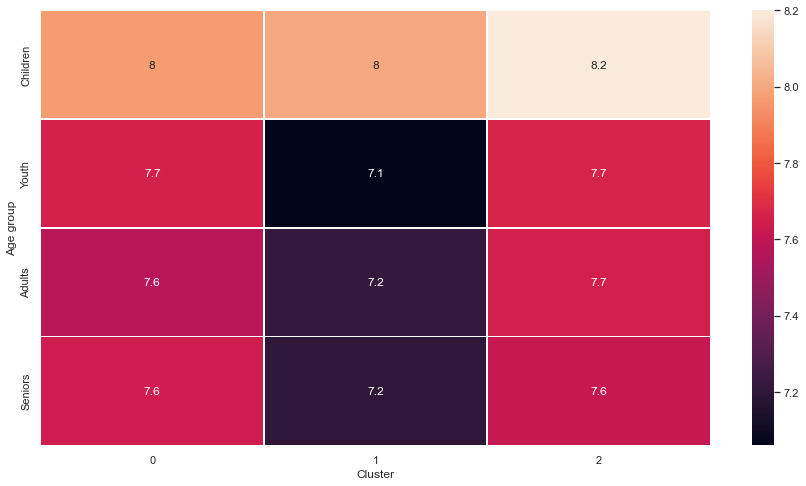

In [26]:
age_groups = ['Children', 'Youth', 'Adults', 'Seniors']

# Plot a heatmap for the dataframe returned by the 'average_rating_per_age_group' function
ages = age_data.pivot('Age group', 'Cluster', 'average_rating')
ages = ages.reindex(index=age_groups)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.heatmap(ages, annot=True, linewidths=.5)

## How the users of each cluster rate based on their location 

In [27]:
# Create a list with the top_10 countries with the most ratings ('unknown' included)
top_10_countries = merged2['location'].value_counts()[:11].index.tolist()
print(top_10_countries)

['usa', 'canada', 'united kingdom', 'australia', 'unknown', 'germany', 'new zealand', 'netherlands', 'spain', 'singapore', 'italy']


In [28]:
# Function for computing the average rating for each of the top_10 locations, in each cluster
def average_rating_per_location():
    
    global location_data # used for the heatmap visualization
    location_data = pd.DataFrame()
    print('{:^90}'.format("\033[1m Average Ratings Based on Users' Location \033[0m"))
    
    for df in cluster_dfs:
        cluster = df["cluster"][0]
        
        table = BeautifulTable(maxwidth=120)
        table.set_style(BeautifulTable.STYLE_GRID)
        table.column_headers = ["Location", "Average rating"]
        
        # Rename every other country (or location) except the top_10, as 'other countries' before performing a grouping
        for index, row in df.iterrows():
            if df.loc[index,'location'] not in top_10_countries:
                df.loc[index,'location'] = 'other countries'
        
        # Compute the average rating for each location
        df = df.groupby('location')['rating'].mean().reset_index(name="average_rating")
    
        # Store the data
        for index, row in df.iterrows():
            table.rows.append([row['location'], float(format(row['average_rating'], '.2f'))])
            location_data = location_data.append([[cluster, row['location'], float(format(row['average_rating'], '.2f'))]])
                        
        table.sort('Average rating', reverse = True)
        print("Cluster " + str(cluster+1) + ":")
        print(table)
    
    location_data.columns = ['Cluster', 'Location', 'average_rating']

In [29]:
average_rating_per_location()

                     Average Ratings Based on Users' Location                     
Cluster 1:
╔═════════════════╤════════════════╗
║    Location     │ Average rating ║
╟─────────────────┼────────────────╢
║       usa       │      7.59      ║
╟─────────────────┼────────────────╢
║      spain      │      7.56      ║
╟─────────────────┼────────────────╢
║ other countries │      7.43      ║
╟─────────────────┼────────────────╢
║ united kingdom  │      7.43      ║
╟─────────────────┼────────────────╢
║     unknown     │      7.43      ║
╟─────────────────┼────────────────╢
║     canada      │      7.33      ║
╟─────────────────┼────────────────╢
║      italy      │      7.22      ║
╟─────────────────┼────────────────╢
║     germany     │      7.21      ║
╟─────────────────┼────────────────╢
║   netherlands   │      7.14      ║
╟─────────────────┼────────────────╢
║    australia    │      7.13      ║
╟─────────────────┼────────────────╢
║    singapore    │      7.03      ║
╟─────────────────

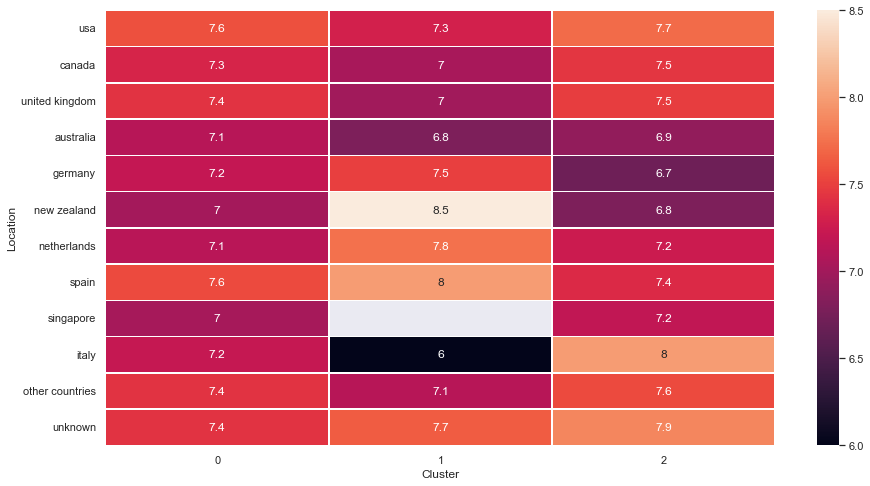

In [30]:
countries = ['usa', 'canada', 'united kingdom', 'australia', 'germany', 'new zealand', 
             'netherlands', 'spain', 'singapore', 'italy', 'other countries', 'unknown']

# Plot a heatmap for the dataframe returned by the 'average_rating_per_location' function
locations = location_data.pivot('Location', 'Cluster', 'average_rating')
locations = locations.reindex(index=countries)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.heatmap(locations, annot=True, linewidths=.5)